In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

To explore time series models, we will continue with the Rossmann sales data. This dataset has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.



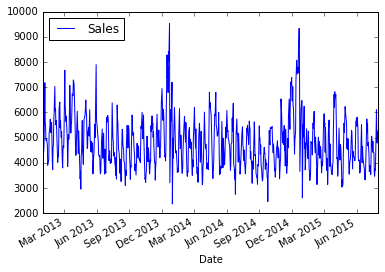

In [3]:
import pandas as pd

# Load the data and set the DateTime index
data = pd.read_csv('./assets/dataset/rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

# Plot the sales over time
store1_open_data[['Sales']].plot()

**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [4]:
store1_data.Sales.autocorr(lag=1) # -0.12

-0.12732514339140219

In [5]:
store1_data.Sales.autocorr(lag=2) # -0.03

-0.034787155707946972

Pandas and statsmodels both provide convenience plots for autocorrelations.

[0, 21, -1, 1]

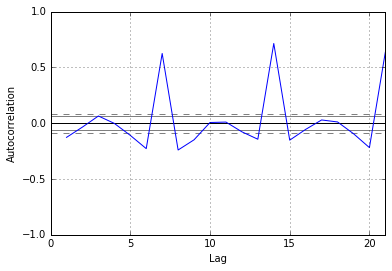

In [7]:
from pandas.tools.plotting import autocorrelation_plot

ax = autocorrelation_plot(store1_data.Sales)
ax.axis([0,21,-1,1])

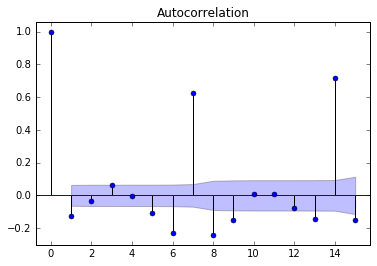

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(store1_data.Sales, lags=15)
plt.show()

**Check**: What caused the spike at 7?

# ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model. 

In [11]:
store1_open_data[['Sales']].head()

,Sales
Date,
2015-07-31,5263
2015-07-30,5020
2015-07-29,4782
2015-07-28,5011
2015-07-27,6102


In [24]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Mon, 08 May 2017   AIC                          12540.651
Time:                        15:47:57   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000    4599.969    4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots       

Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

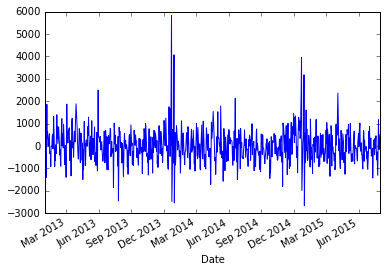

In [25]:
model.resid.plot()

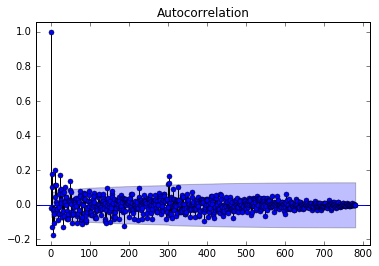

In [26]:
plot_acf(model.resid)
plt.show()

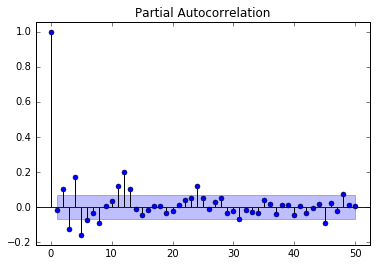

In [27]:
plot_pacf(model.resid, lags=50)
plt.show()

Becuase of the errors, it doesn't look like an AR model is good enough -- the data isn't stationary. So let's expand to an `ARMA` model.

In [28]:
model = ARMA(store1_sales_data, (1, 1)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Mon, 08 May 2017   AIC                          12542.222
Time:                        15:48:04   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.5960     84.702     56.228      0.000    4596.583    4928.609
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654    

In [30]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (2, 0, 2)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 2)   Log Likelihood               -6243.725
Method:                       css-mle   S.D. of innovations            716.957
Date:                Mon, 08 May 2017   AIC                          12499.449
Time:                        15:48:48   BIC                          12527.413
Sample:                    07-31-2015   HQIC                         12510.204
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4761.3837     75.652     62.938      0.000    4613.109    4909.659
ar.L1.Sales    -0.2277      0.056     -4.064      0.000      -0.338      -0.118
ar.L2.Sales     0.4689      0.057      8.271    

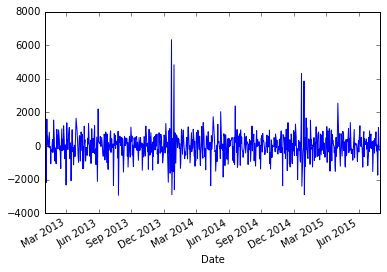

In [31]:
store1_sales_data.Sales.diff(1).autocorr(1) #-0.181

store1_sales_data.Sales.diff(1).plot()
plt.show()

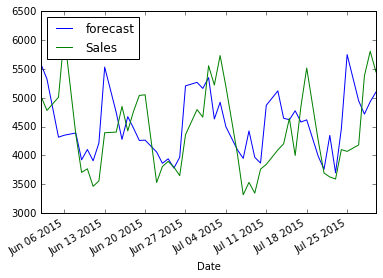

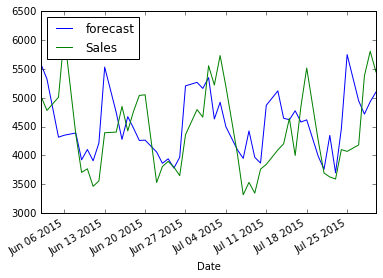

In [32]:
model.plot_predict(1, 50)